In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, TensorDataset

# 解决服务器挂掉的问题
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model_path = "D:/LTX/code_comment_inconsistency_detection/microsoft-codebert-base"
model = RobertaForSequenceClassification.from_pretrained(model_path,hidden_dropout_prob=0.6)
model.to(device)
model.eval()
model.zero_grad()

tokenizer = RobertaTokenizer.from_pretrained(model_path)

print(sum([i.nelement() for i in model.parameters()]) / 10000)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at D:/LTX/code_comment_inconsistency_detection/microsoft-codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


12464.717


In [4]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.6, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [5]:
model.config.hidden_size

768

In [6]:
tokenizer.cls_token_id ,tokenizer.sep_token_id

(0, 2)

In [7]:
MAX_LEN = 512
MAX_EPOCHS = 100
BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_CLASSES = 2
WEIGTH_DECAY = 1e-3

处理数据  提取出 old_code_raw old_comment_raw label 三列，并且对old_code_raw的值中的\n去掉

In [8]:
def retrieve_train_data():
    train_param = pd.read_json("D:/LTX/code_comment_inconsistency_detection/data/param/train.json")
    train_return = pd.read_json("D:/LTX/code_comment_inconsistency_detection/data/return/train.json")
    train_summary = pd.read_json("D:/LTX/code_comment_inconsistency_detection/data/summary/train.json")
    train_df = pd.concat([train_summary,train_param, train_return], axis=0)
    return train_df
def retrieve_valid_data():
    valid_param = pd.read_json("D:/LTX/code_comment_inconsistency_detection/data/param/valid.json")
    valid_return = pd.read_json("D:/LTX/code_comment_inconsistency_detection/data/return/valid.json")
    valid_summary = pd.read_json("D:/LTX/code_comment_inconsistency_detection/data/summary/valid.json")
    valid_df = pd.concat([valid_summary,valid_param, valid_return ], axis=0)
    return valid_df

In [9]:
train_df = retrieve_train_data()
valid_df = retrieve_valid_data()
train_df.head()

,id,label,comment_type,old_comment_raw,old_comment_subtokens,new_comment_raw,new_comment_subtokens,span_minimal_diff_comment_subtokens,old_code_raw,old_code_subtokens,new_code_raw,new_code_subtokens,span_diff_code_subtokens,token_diff_code_subtokens
0,grails-plugins_grails-plugin-converters-5-Asso...,1,Summary,Parses the given JSON and returns ether a JSON...,"[parses, the, given, json, and, returns, ether...",Parses the given JSON and returns either a JSO...,"[parses, the, given, json, and, returns, eithe...","[<REPLACE_OLD>, ether, <REPLACE_NEW>, either, ...",public static JSONElement parse(InputStrea...,"[public, static, jsonelement, parse, (, input,...",public static JSONElement parse(InputStrea...,"[public, static, jsonelement, parse, (, input,...","[<KEEP>, public, static, jsonelement, parse, (...","[<KEEP>, public, <KEEP>, static, <KEEP>, jsone..."
1,jitsi_jitsi-4343-FirstSentence-0,0,Summary,Loads an image from a given image identifier.,"[loads, an, image, from, a, given, image, iden...",Loads an image from a given image identifier.,"[loads, an, image, from, a, given, image, iden...",[],public static byte[] getImageInBytes(Strin...,"[public, static, byte, [, ], get, image, in, b...",public static byte[] getImageInBytes(Strin...,"[public, static, byte, [, ], get, image, in, b...","[<KEEP>, public, static, byte, [, ], get, imag...","[<KEEP>, public, <KEEP>, static, <KEEP>, byte,..."
2,dropwizard_metrics-26-Associations-FirstSentence,1,Summary,Creates a new CounterMetric and registers it ...,"[creates, a, new, counter, metric, and, regist...",Creates a new com.yammer.metrics.core.Counter...,"[creates, a, new, com, ., yammer, ., metrics, ...","[<INSERT_OLD_KEEP_BEFORE>, new, <INSERT_NEW_KE...",public static CounterMetric newCounter(Cla...,"[public, static, counter, metric, new, counter...",public static Counter newCounter(Class<?> ...,"[public, static, counter, new, counter, (, cla...","[<KEEP>, public, static, counter, <KEEP_END>, ...","[<KEEP>, public, <KEEP>, static, <KEEP>, count..."
3,google_ExoPlayer-92-FirstSentence-0,0,Summary,Derives a sample format corresponding to a giv...,"[derives, a, sample, format, corresponding, to...",Derives a sample format corresponding to a giv...,"[derives, a, sample, format, corresponding, to...",[],private static Format getSampleFormat(Format...,"[private, static, format, get, sample, format,...",private static Format getSampleFormat(Format...,"[private, static, format, get, sample, format,...","[<KEEP>, private, static, format, get, sample,...","[<KEEP>, private, <KEEP>, static, <KEEP>, form..."
4,slachiewicz_orekit-main-661-Associations-First...,1,Summary,Revert a rotation/rotation rate pair.,"[revert, a, rotation, /, rotation, rate, pair, .]",Revert a rotation/rotation rate/ rotation acce...,"[revert, a, rotation, /, rotation, rate, /, ro...","[<REPLACE_OLD>, pair, <REPLACE_NEW>, /, rotati...",public AngularCoordinates revert() {\n ...,"[public, angular, coordinates, revert, (, ), {...",public AngularCoordinates revert() {\n ...,"[public, angular, coordinates, revert, (, ), {...","[<KEEP>, public, angular, coordinates, revert,...","[<KEEP>, public, <KEEP>, angular, <KEEP>, coor..."


In [10]:
valid_df.head()

,id,label,comment_type,old_comment_raw,old_comment_subtokens,new_comment_raw,new_comment_subtokens,span_minimal_diff_comment_subtokens,old_code_raw,old_code_subtokens,new_code_raw,new_code_subtokens,span_diff_code_subtokens,token_diff_code_subtokens
0,todoroo_astrid-987-FirstSentence-0,1,Summary,Return SQL selector query for getting tasks wi...,"[return, sql, selector, query, for, getting, t...",Return SQL selector query for getting tasks wi...,"[return, sql, selector, query, for, getting, t...","[<INSERT_OLD_KEEP_BEFORE>, tag, <INSERT_NEW_KE...",public QueryTemplate queryTemplate(Cri...,"[public, query, template, query, template, (, ...",public static QueryTemplate queryTempl...,"[public, static, query, template, query, templ...","[<KEEP>, public, <KEEP_END>, <INSERT>, static,...","[<KEEP>, public, <INSERT>, static, <KEEP>, que..."
1,Red5_red5_server-43-FirstSentence-0,0,Summary,Return period of ghost connections cleanup tas...,"[return, period, of, ghost, connections, clean...",Return period of ghost connections cleanup tas...,"[return, period, of, ghost, connections, clean...",[],public int getGhostConnsCleanupPeriod() {\...,"[public, int, get, ghost, conns, cleanup, peri...",public int getGhostConnsCleanupPeriod() {\...,"[public, int, get, ghost, conns, cleanup, peri...","[<KEEP>, public, int, get, ghost, conns, clean...","[<KEEP>, public, <KEEP>, int, <KEEP>, get, <KE..."
2,nickman_Rindle-11-Associations-FirstSentence,1,Summary,Allocates an initialized and initially unlocke...,"[allocates, an, initialized, and, initially, u...",Allocates an initialized and initially unlocke...,"[allocates, an, initialized, and, initially, u...","[<INSERT_OLD_KEEP_BEFORE>, unlocked, <INSERT_N...",\tpublic static long allocateSpinLock() {\r\n\...,"[public, static, long, allocate, spin, lock, (...",\tpublic static SpinLock allocateSpinLock() {\...,"[public, static, spin, lock, allocate, spin, l...","[<KEEP>, public, static, <KEEP_END>, <REPLACE_...","[<KEEP>, public, <KEEP>, static, <REPLACE_OLD>..."
3,h2oai_h2o_2-427-FirstSentence-0,0,Summary,Rebalance a frame for load balancing,"[rebalance, a, frame, for, load, balancing]",Rebalance a frame for load balancing,"[rebalance, a, frame, for, load, balancing]",[],"private Frame reBalance(final Frame fr, bool...","[private, frame, re, balance, (, final, frame,...",private static Frame reBalance(final Frame f...,"[private, static, frame, re, balance, (, final...","[<KEEP>, private, <KEEP_END>, <INSERT>, static...","[<KEEP>, private, <INSERT>, static, <KEEP>, fr..."
4,sonatype_sonatype-aether-11-Associations-First...,1,Summary,Sets the host of this proxy.,"[sets, the, host, of, this, proxy, .]",Sets the host of the proxy.,"[sets, the, host, of, the, proxy, .]","[<REPLACE_OLD>, this, <REPLACE_NEW>, the, <REP...",public Proxy setHost( String host )\n {...,"[public, proxy, set, host, (, string, host, ),...",public Proxy setHost( String host )\n {...,"[public, proxy, set, host, (, string, host, ),...","[<KEEP>, public, proxy, set, host, (, string, ...","[<KEEP>, public, <KEEP>, proxy, <KEEP>, set, <..."


In [11]:
def format_data(df):
    old_code_raw = df['new_code_raw']
    old_code_raw = old_code_raw.values
    old_code_raw = [str(ele) for ele in old_code_raw]
       
    multi_line_old_code = []
    for i in range(len(old_code_raw)):
        multi_line_test = old_code_raw[i].replace('\n', ' ')   # 去掉\n
        multi_line_test = ' '.join(multi_line_test.split())    # 把多余空格变成一个空格
        multi_line_old_code.append(multi_line_test) 
     
    old_comment_raw = df['old_comment_raw']
    old_comment_raw = old_comment_raw.values
    old_comment_raw = [str(ele) for ele in old_comment_raw]
    multi_line_old_comment = []
    for i in range(len(old_comment_raw)):
        multi_line_test = ' '.join(old_comment_raw[i].split())    # 把多余空格变成一个空格
        multi_line_old_comment.append(multi_line_test)  
    
    df['new_code_raw'] = multi_line_old_code
    df['old_comment_raw'] = multi_line_old_comment
    
    return df

In [12]:
train_df_clean = format_data(train_df)
train_df_clean.head()

,id,label,comment_type,old_comment_raw,old_comment_subtokens,new_comment_raw,new_comment_subtokens,span_minimal_diff_comment_subtokens,old_code_raw,old_code_subtokens,new_code_raw,new_code_subtokens,span_diff_code_subtokens,token_diff_code_subtokens
0,grails-plugins_grails-plugin-converters-5-Asso...,1,Summary,Parses the given JSON and returns ether a JSON...,"[parses, the, given, json, and, returns, ether...",Parses the given JSON and returns either a JSO...,"[parses, the, given, json, and, returns, eithe...","[<REPLACE_OLD>, ether, <REPLACE_NEW>, either, ...",public static JSONElement parse(InputStrea...,"[public, static, jsonelement, parse, (, input,...",public static JSONElement parse(InputStream is...,"[public, static, jsonelement, parse, (, input,...","[<KEEP>, public, static, jsonelement, parse, (...","[<KEEP>, public, <KEEP>, static, <KEEP>, jsone..."
1,jitsi_jitsi-4343-FirstSentence-0,0,Summary,Loads an image from a given image identifier.,"[loads, an, image, from, a, given, image, iden...",Loads an image from a given image identifier.,"[loads, an, image, from, a, given, image, iden...",[],public static byte[] getImageInBytes(Strin...,"[public, static, byte, [, ], get, image, in, b...",public static byte[] getImageInBytes(String im...,"[public, static, byte, [, ], get, image, in, b...","[<KEEP>, public, static, byte, [, ], get, imag...","[<KEEP>, public, <KEEP>, static, <KEEP>, byte,..."
2,dropwizard_metrics-26-Associations-FirstSentence,1,Summary,Creates a new CounterMetric and registers it u...,"[creates, a, new, counter, metric, and, regist...",Creates a new com.yammer.metrics.core.Counter...,"[creates, a, new, com, ., yammer, ., metrics, ...","[<INSERT_OLD_KEEP_BEFORE>, new, <INSERT_NEW_KE...",public static CounterMetric newCounter(Cla...,"[public, static, counter, metric, new, counter...",public static Counter newCounter(Class<?> klas...,"[public, static, counter, new, counter, (, cla...","[<KEEP>, public, static, counter, <KEEP_END>, ...","[<KEEP>, public, <KEEP>, static, <KEEP>, count..."
3,google_ExoPlayer-92-FirstSentence-0,0,Summary,Derives a sample format corresponding to a giv...,"[derives, a, sample, format, corresponding, to...",Derives a sample format corresponding to a giv...,"[derives, a, sample, format, corresponding, to...",[],private static Format getSampleFormat(Format...,"[private, static, format, get, sample, format,...",private static Format getSampleFormat(Format c...,"[private, static, format, get, sample, format,...","[<KEEP>, private, static, format, get, sample,...","[<KEEP>, private, <KEEP>, static, <KEEP>, form..."
4,slachiewicz_orekit-main-661-Associations-First...,1,Summary,Revert a rotation/rotation rate pair.,"[revert, a, rotation, /, rotation, rate, pair, .]",Revert a rotation/rotation rate/ rotation acce...,"[revert, a, rotation, /, rotation, rate, /, ro...","[<REPLACE_OLD>, pair, <REPLACE_NEW>, /, rotati...",public AngularCoordinates revert() {\n ...,"[public, angular, coordinates, revert, (, ), {...",public AngularCoordinates revert() { return ne...,"[public, angular, coordinates, revert, (, ), {...","[<KEEP>, public, angular, coordinates, revert,...","[<KEEP>, public, <KEEP>, angular, <KEEP>, coor..."


In [13]:
valid_df_clean = format_data(valid_df)
valid_df_clean.head()

,id,label,comment_type,old_comment_raw,old_comment_subtokens,new_comment_raw,new_comment_subtokens,span_minimal_diff_comment_subtokens,old_code_raw,old_code_subtokens,new_code_raw,new_code_subtokens,span_diff_code_subtokens,token_diff_code_subtokens
0,todoroo_astrid-987-FirstSentence-0,1,Summary,Return SQL selector query for getting tasks wi...,"[return, sql, selector, query, for, getting, t...",Return SQL selector query for getting tasks wi...,"[return, sql, selector, query, for, getting, t...","[<INSERT_OLD_KEEP_BEFORE>, tag, <INSERT_NEW_KE...",public QueryTemplate queryTemplate(Cri...,"[public, query, template, query, template, (, ...",public static QueryTemplate queryTemplate(Crit...,"[public, static, query, template, query, templ...","[<KEEP>, public, <KEEP_END>, <INSERT>, static,...","[<KEEP>, public, <INSERT>, static, <KEEP>, que..."
1,Red5_red5_server-43-FirstSentence-0,0,Summary,Return period of ghost connections cleanup tas...,"[return, period, of, ghost, connections, clean...",Return period of ghost connections cleanup tas...,"[return, period, of, ghost, connections, clean...",[],public int getGhostConnsCleanupPeriod() {\...,"[public, int, get, ghost, conns, cleanup, peri...",public int getGhostConnsCleanupPeriod() { retu...,"[public, int, get, ghost, conns, cleanup, peri...","[<KEEP>, public, int, get, ghost, conns, clean...","[<KEEP>, public, <KEEP>, int, <KEEP>, get, <KE..."
2,nickman_Rindle-11-Associations-FirstSentence,1,Summary,Allocates an initialized and initially unlocke...,"[allocates, an, initialized, and, initially, u...",Allocates an initialized and initially unlocke...,"[allocates, an, initialized, and, initially, u...","[<INSERT_OLD_KEEP_BEFORE>, unlocked, <INSERT_N...",\tpublic static long allocateSpinLock() {\r\n\...,"[public, static, long, allocate, spin, lock, (...",public static SpinLock allocateSpinLock() { lo...,"[public, static, spin, lock, allocate, spin, l...","[<KEEP>, public, static, <KEEP_END>, <REPLACE_...","[<KEEP>, public, <KEEP>, static, <REPLACE_OLD>..."
3,h2oai_h2o_2-427-FirstSentence-0,0,Summary,Rebalance a frame for load balancing,"[rebalance, a, frame, for, load, balancing]",Rebalance a frame for load balancing,"[rebalance, a, frame, for, load, balancing]",[],"private Frame reBalance(final Frame fr, bool...","[private, frame, re, balance, (, final, frame,...","private static Frame reBalance(final Frame fr,...","[private, static, frame, re, balance, (, final...","[<KEEP>, private, <KEEP_END>, <INSERT>, static...","[<KEEP>, private, <INSERT>, static, <KEEP>, fr..."
4,sonatype_sonatype-aether-11-Associations-First...,1,Summary,Sets the host of this proxy.,"[sets, the, host, of, this, proxy, .]",Sets the host of the proxy.,"[sets, the, host, of, the, proxy, .]","[<REPLACE_OLD>, this, <REPLACE_NEW>, the, <REP...",public Proxy setHost( String host )\n {...,"[public, proxy, set, host, (, string, host, ),...",public Proxy setHost( String host ) { return n...,"[public, proxy, set, host, (, string, host, ),...","[<KEEP>, public, proxy, set, host, (, string, ...","[<KEEP>, public, <KEEP>, proxy, <KEEP>, set, <..."


In [14]:
class CocoDataset(Dataset):
    def __init__(self, df):
        self.df = df
        model_path = "D:/LTX/code_comment_inconsistency_detection/microsoft-codebert-base"
        
        self.tokenizer = RobertaTokenizer.from_pretrained(model_path, do_lower_case=False)
        self.data = self.load_data(self.df)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    def load_data(self, df):
        token_ids = []
        mask_ids = []
        seg_ids = []
        labels = []
        
        code_list = df['new_code_raw'].to_list() 
        comment_list = df['old_comment_raw'].to_list()
        label_list = df['label'].to_list()

        for (code, comment, label) in zip(code_list, comment_list, label_list):
            code_id = self.tokenizer(code, add_special_tokens=False, truncation=True, max_length=MAX_LEN)
            comment_id = self.tokenizer(comment, add_special_tokens=False, truncation=True, max_length=MAX_LEN)
            code_id = code_id["input_ids"]
            comment_id = comment_id["input_ids"]
            
            # want [CLS] comment tokens [SEP] code tokens [SEP]
            pair_token_ids = [self.tokenizer.cls_token_id] + comment_id + [self.tokenizer.sep_token_id] + code_id + [self.tokenizer.sep_token_id]
            pair_token_ids = self.truncate(pair_token_ids)
            code_len = len(code_id)
            comment_len = len(comment_id)
            
            attention_mask_ids = torch.tensor([1] * (code_len + comment_len + 3)) # mask padded values
            attention_mask_ids = self.truncate(attention_mask_ids)

            
            token_ids.append(torch.tensor(pair_token_ids))
            mask_ids.append(attention_mask_ids)
            labels.append(label)
            
        token_ids = pad_sequence(token_ids, batch_first=True)
        mask_ids = pad_sequence(mask_ids, batch_first=True)
        labels = torch.tensor(labels)
        
        dataset = TensorDataset(token_ids, mask_ids, labels)
        return dataset

    def truncate(self, ids):
        return ids[:MAX_LEN] if len(ids) > MAX_LEN else ids

In [15]:
train_data = CocoDataset(train_df_clean)
valid_data = CocoDataset(valid_df_clean)
train_data,valid_data

(<__main__.CocoDataset at 0x2269dcfe7d0>,
 <__main__.CocoDataset at 0x2269dcfe4a0>)

train

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(predicted_labels, gold_labels):
    predicted_labels = [label.item() for label in predicted_labels]
    gold_labels = [label.item() for label in gold_labels]

    assert len(predicted_labels) == len(gold_labels)

    precision = precision_score(gold_labels, predicted_labels, zero_division=0)
    recall = recall_score(gold_labels, predicted_labels, zero_division=0)
    f1 = f1_score(gold_labels, predicted_labels, zero_division=0)
    accuracy = accuracy_score(gold_labels, predicted_labels) 

    return precision, recall, f1, accuracy

In [17]:
from transformers.utils.notebook import format_time
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
def train(model,train_data_t,valid_data_t,patience=10):

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
    valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE)

    best_f1 = 0.0
    epochs_without_improvement = 0
    
    total_steps = len(train_loader) * MAX_EPOCHS
    print("   Train batch size = {}".format(BATCH_SIZE))
    print("   Total steps = {}".format(total_steps))
    print(f"   Training Start!")
    train_losses = []
    valid_losses = []
    times =  0
    for epoch in range(MAX_EPOCHS):
        times = times + 1
        start = time.time()
        model.to(device)
        model.train()
        
        string_colmn_name = "input_data    label    prediction_label"
        file_name = 'check_codebert_valid_dataset_epoch_{}'
        with open(file_name.format(times)+'.txt', 'w',encoding='utf-8') as f:
            f.write(string_colmn_name)
        
        train_loss = 0.0
        predictions = []
        gold_labels = []
        times = 0
        for batch_idx, (sequence, attention_masks, labels) in enumerate(tqdm(train_loader, desc="Training", leave=True)):
            sequence = sequence.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
#             print(batch_idx,sequence,attention_masks,labels)
            
            outputs = model(sequence, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            prediction = outputs.logits
            times = times + 1
#             print(times)

            train_loss += loss.item()
            prediction = torch.argmax(prediction, dim=-1)

            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)  # 梯度截断

            optimizer.step()
            optimizer.zero_grad()

            predictions.extend(prediction)
            gold_labels.extend(labels)

        train_loss = train_loss / len(train_loader)
        train_precision, train_recall, train_f1, train_acc = compute_metrics(predictions, gold_labels)
        train_time = format_time(time.time()-start)

        model.eval()
        valid_loss = 0.0
        predictions = []
        gold_labels = []

        with torch.no_grad():
            for batch_idx, (sequence, attention_masks, labels) in enumerate(valid_loader):
                sequence = sequence.to(device)
                attention_masks = attention_masks.to(device)
                labels = labels.to(device)

                outputs = model(sequence, attention_mask=attention_masks, labels=labels)
                loss = outputs.loss
                prediction = outputs.logits
                
                valid_loss += loss.item()
                prediction = torch.argmax(prediction, dim=-1)

                predictions.extend(prediction)
                gold_labels.extend(labels)
                
                labels_cpu = labels.cpu()
                prediction_cpu = prediction.cpu()
                input_data = str([tokenizer.decode(ids,skip_special_tokens=True) for ids in sequence])
                with open(file_name.format(times) +'.txt', 'a',encoding='utf-8') as f:
                    f.write(input_data)
                    f.write('%s\n' % labels_cpu.numpy().tolist())
                    f.write('%s\n' % prediction_cpu.numpy().tolist())

        valid_time = format_time(time.time() - start)
        valid_loss = valid_loss / len(valid_loader)
        valid_precision, valid_recall, valid_f1, valid_acc = compute_metrics(predictions, gold_labels)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        if valid_f1 != best_f1:
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                print(f"New best validation f1 of {valid_f1:.3f}. Saving model.")
                torch.save(model, "save_CBmodel.pt")
            epochs_without_improvement = 0      
        else:
            epochs_without_improvement += 1
            
        # 如果验证集上的f1连续patience个epoch没有变化，则停止训练
        if epochs_without_improvement == patience:
            print('Early stopping at epoch {}...'.format(epoch+1))
            break

        end = time.time()
        hours, rem = divmod(end - start, 3600)
        min, sec = divmod(rem, 60)

        print(f"Epoch {epoch + 1}: train_loss: {train_loss:.3f} train_precision: {train_precision:.3f} train_recall: {train_recall:.3f} train_f1: {train_f1:.3f} train_acc: {train_acc:.3f}")
        print(f"\t valid_loss: {valid_loss:.3f} valid_precision: {valid_precision:.3f} valid_recall: {valid_recall:.3f} valid_f1: {valid_f1:.3f} valid_acc: {valid_acc:.3f}")
        print("\t {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(min), sec))

    print('   Training Completed!')
    return train_losses,valid_losses

In [18]:
train_losses,valid_losses = train(model,train_data,valid_data)

   Train batch size = 8
   Total steps = 412400
   Training Start!


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:22<00:00,  5.14it/s]


New best validation f1 of 0.473. Saving model.
Epoch 1: train_loss: 0.719 train_precision: 0.501 train_recall: 0.496 train_f1: 0.498 train_acc: 0.501
	 valid_loss: 0.692 valid_precision: 0.543 valid_recall: 0.419 valid_f1: 0.473 valid_acc: 0.533
	 00:14:43.38


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:16<00:00,  5.18it/s]


New best validation f1 of 0.664. Saving model.
Epoch 2: train_loss: 0.715 train_precision: 0.502 train_recall: 0.495 train_f1: 0.498 train_acc: 0.502
	 valid_loss: 0.692 valid_precision: 0.508 valid_recall: 0.960 valid_f1: 0.664 valid_acc: 0.515
	 00:14:37.85


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:15<00:00,  5.18it/s]


Epoch 3: train_loss: 0.712 train_precision: 0.500 train_recall: 0.493 train_f1: 0.496 train_acc: 0.500
	 valid_loss: 0.694 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:31.32


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:16<00:00,  5.18it/s]


Epoch 4: train_loss: 0.710 train_precision: 0.500 train_recall: 0.506 train_f1: 0.503 train_acc: 0.500
	 valid_loss: 0.693 valid_precision: 0.417 valid_recall: 0.008 valid_f1: 0.016 valid_acc: 0.498
	 00:14:32.33


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:16<00:00,  5.18it/s]


New best validation f1 of 0.667. Saving model.
Epoch 5: train_loss: 0.706 train_precision: 0.503 train_recall: 0.497 train_f1: 0.500 train_acc: 0.503
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:37.77


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:16<00:00,  5.18it/s]


Epoch 6: train_loss: 0.706 train_precision: 0.502 train_recall: 0.490 train_f1: 0.496 train_acc: 0.502
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:32.51


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 7: train_loss: 0.703 train_precision: 0.505 train_recall: 0.503 train_f1: 0.504 train_acc: 0.505
	 valid_loss: 0.694 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:33.17


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:20<00:00,  5.15it/s]


Epoch 8: train_loss: 0.704 train_precision: 0.500 train_recall: 0.496 train_f1: 0.498 train_acc: 0.500
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:35.33


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:20<00:00,  5.15it/s]


Epoch 9: train_loss: 0.703 train_precision: 0.500 train_recall: 0.492 train_f1: 0.496 train_acc: 0.500
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:35.66


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 10: train_loss: 0.701 train_precision: 0.506 train_recall: 0.485 train_f1: 0.495 train_acc: 0.506
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:36.43


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 11: train_loss: 0.702 train_precision: 0.500 train_recall: 0.471 train_f1: 0.485 train_acc: 0.500
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:34.80


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 12: train_loss: 0.700 train_precision: 0.504 train_recall: 0.480 train_f1: 0.492 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:36.53


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 13: train_loss: 0.699 train_precision: 0.501 train_recall: 0.487 train_f1: 0.494 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:35.96


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 14: train_loss: 0.699 train_precision: 0.503 train_recall: 0.483 train_f1: 0.493 train_acc: 0.503
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:34.93


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 15: train_loss: 0.698 train_precision: 0.504 train_recall: 0.484 train_f1: 0.494 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:35.15


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 16: train_loss: 0.698 train_precision: 0.505 train_recall: 0.494 train_f1: 0.499 train_acc: 0.505
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:35.59


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 17: train_loss: 0.698 train_precision: 0.506 train_recall: 0.505 train_f1: 0.506 train_acc: 0.506
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:37.83


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 18: train_loss: 0.697 train_precision: 0.503 train_recall: 0.484 train_f1: 0.493 train_acc: 0.503
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:34.55


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 19: train_loss: 0.697 train_precision: 0.505 train_recall: 0.480 train_f1: 0.492 train_acc: 0.505
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:37.00


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 20: train_loss: 0.697 train_precision: 0.504 train_recall: 0.486 train_f1: 0.495 train_acc: 0.503
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:34.65


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:19<00:00,  5.16it/s]


Epoch 21: train_loss: 0.697 train_precision: 0.502 train_recall: 0.466 train_f1: 0.483 train_acc: 0.502
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:34.83


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 22: train_loss: 0.696 train_precision: 0.503 train_recall: 0.458 train_f1: 0.480 train_acc: 0.503
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:33.40


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:18<00:00,  5.17it/s]


Epoch 23: train_loss: 0.697 train_precision: 0.501 train_recall: 0.449 train_f1: 0.474 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:36.28


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:18<00:00,  5.17it/s]


Epoch 24: train_loss: 0.696 train_precision: 0.501 train_recall: 0.465 train_f1: 0.482 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:33.83


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 25: train_loss: 0.696 train_precision: 0.504 train_recall: 0.469 train_f1: 0.486 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:34.63


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:16<00:00,  5.18it/s]


Epoch 26: train_loss: 0.695 train_precision: 0.499 train_recall: 0.480 train_f1: 0.489 train_acc: 0.499
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:32.07


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 27: train_loss: 0.696 train_precision: 0.500 train_recall: 0.463 train_f1: 0.481 train_acc: 0.500
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:33.14


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 28: train_loss: 0.696 train_precision: 0.496 train_recall: 0.447 train_f1: 0.470 train_acc: 0.496
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:33.02


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:16<00:00,  5.18it/s]


Epoch 29: train_loss: 0.695 train_precision: 0.504 train_recall: 0.479 train_f1: 0.491 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:31.48


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 30: train_loss: 0.695 train_precision: 0.502 train_recall: 0.472 train_f1: 0.487 train_acc: 0.502
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:33.20


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 31: train_loss: 0.695 train_precision: 0.502 train_recall: 0.440 train_f1: 0.469 train_acc: 0.502
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:32.75


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 32: train_loss: 0.695 train_precision: 0.504 train_recall: 0.466 train_f1: 0.484 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:33.98


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 33: train_loss: 0.694 train_precision: 0.502 train_recall: 0.444 train_f1: 0.471 train_acc: 0.502
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:32.67


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 34: train_loss: 0.695 train_precision: 0.498 train_recall: 0.450 train_f1: 0.473 train_acc: 0.498
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:33.40


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 35: train_loss: 0.694 train_precision: 0.506 train_recall: 0.415 train_f1: 0.456 train_acc: 0.505
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:33.57


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 36: train_loss: 0.695 train_precision: 0.500 train_recall: 0.433 train_f1: 0.464 train_acc: 0.500
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:35.29


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:18<00:00,  5.17it/s]


Epoch 37: train_loss: 0.695 train_precision: 0.498 train_recall: 0.431 train_f1: 0.462 train_acc: 0.498
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:34.27


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:18<00:00,  5.17it/s]


Epoch 38: train_loss: 0.694 train_precision: 0.501 train_recall: 0.437 train_f1: 0.467 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:35.83


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:17<00:00,  5.17it/s]


Epoch 39: train_loss: 0.694 train_precision: 0.501 train_recall: 0.454 train_f1: 0.476 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:33.17


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:16<00:00,  5.18it/s]


Epoch 40: train_loss: 0.694 train_precision: 0.504 train_recall: 0.431 train_f1: 0.465 train_acc: 0.503
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:32.37


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:23<00:00,  5.13it/s]


Epoch 41: train_loss: 0.695 train_precision: 0.498 train_recall: 0.414 train_f1: 0.452 train_acc: 0.498
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:39.88


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.12it/s]


Epoch 42: train_loss: 0.694 train_precision: 0.500 train_recall: 0.429 train_f1: 0.462 train_acc: 0.500
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:40.66


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.12it/s]


Epoch 43: train_loss: 0.694 train_precision: 0.496 train_recall: 0.435 train_f1: 0.464 train_acc: 0.497
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:40.79


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:23<00:00,  5.13it/s]


Epoch 44: train_loss: 0.694 train_precision: 0.503 train_recall: 0.436 train_f1: 0.467 train_acc: 0.502
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:41.98


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Epoch 45: train_loss: 0.694 train_precision: 0.505 train_recall: 0.395 train_f1: 0.444 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:41.22


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Epoch 46: train_loss: 0.694 train_precision: 0.503 train_recall: 0.403 train_f1: 0.447 train_acc: 0.503
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:40.12


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:23<00:00,  5.13it/s]


Epoch 47: train_loss: 0.694 train_precision: 0.501 train_recall: 0.423 train_f1: 0.459 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:40.27


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Epoch 48: train_loss: 0.694 train_precision: 0.504 train_recall: 0.423 train_f1: 0.460 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:40.89


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Epoch 49: train_loss: 0.694 train_precision: 0.504 train_recall: 0.427 train_f1: 0.462 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:40.32


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.12it/s]


Epoch 50: train_loss: 0.694 train_precision: 0.505 train_recall: 0.407 train_f1: 0.451 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:41.18


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:23<00:00,  5.13it/s]


Epoch 51: train_loss: 0.694 train_precision: 0.494 train_recall: 0.370 train_f1: 0.423 train_acc: 0.496
	 valid_loss: 0.693 valid_precision: 0.000 valid_recall: 0.000 valid_f1: 0.000 valid_acc: 0.500
	 00:14:39.91


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Epoch 52: train_loss: 0.694 train_precision: 0.501 train_recall: 0.431 train_f1: 0.464 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:40.46


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Epoch 53: train_loss: 0.694 train_precision: 0.497 train_recall: 0.381 train_f1: 0.431 train_acc: 0.498
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:40.13


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:23<00:00,  5.13it/s]


Epoch 54: train_loss: 0.694 train_precision: 0.502 train_recall: 0.424 train_f1: 0.459 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:39.54


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Epoch 55: train_loss: 0.694 train_precision: 0.501 train_recall: 0.402 train_f1: 0.446 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:40.17


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:25<00:00,  5.12it/s]


Epoch 56: train_loss: 0.694 train_precision: 0.502 train_recall: 0.371 train_f1: 0.427 train_acc: 0.501
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:42.08


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Epoch 57: train_loss: 0.694 train_precision: 0.503 train_recall: 0.386 train_f1: 0.437 train_acc: 0.502
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:40.02


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:23<00:00,  5.13it/s]


Epoch 58: train_loss: 0.694 train_precision: 0.499 train_recall: 0.410 train_f1: 0.450 train_acc: 0.499
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:39.66


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:23<00:00,  5.13it/s]


Epoch 59: train_loss: 0.694 train_precision: 0.499 train_recall: 0.386 train_f1: 0.435 train_acc: 0.499
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:43.00


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Epoch 60: train_loss: 0.694 train_precision: 0.505 train_recall: 0.391 train_f1: 0.441 train_acc: 0.504
	 valid_loss: 0.693 valid_precision: 0.500 valid_recall: 1.000 valid_f1: 0.667 valid_acc: 0.500
	 00:14:41.20


Training: 100%|████████████████████████████████████████████████████████████████████| 4124/4124 [13:24<00:00,  5.13it/s]


Early stopping at epoch 61...
   Training Completed!


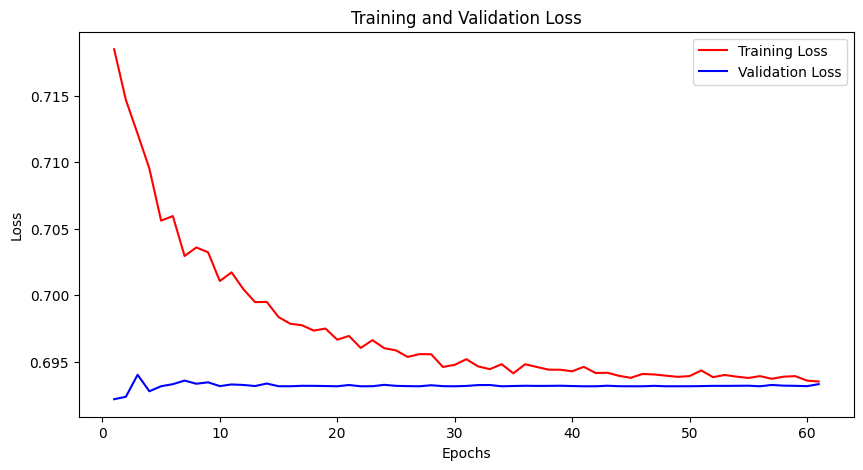

In [19]:
import matplotlib.pyplot as plt

# 假设train_losses和val_losses分别存储了训练损失和验证损失
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'r-', label='Training Loss')
plt.plot(epochs, valid_losses, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test

In [20]:
def retrieve_test_data():
    test_param = pd.read_json("D:/LTX/code_comment_inconsistency_detection/data/param/test.json")
    test_return = pd.read_json("D:/LTX/code_comment_inconsistency_detection/data/return/test.json")
    test_summary = pd.read_json("D:/LTX/code_comment_inconsistency_detection/data/summary/test.json")
    test_df = pd.concat([test_summary,test_param, test_return], axis=0)
    # test_df = test_df[:1000]
    return test_df

In [21]:
def test(model, test_loader, device):
    model.eval()
    test_loss = 0.0
    predictions = []
    gold_labels = []

    with torch.no_grad():
        for batch_idx, (sequence, attention_masks, labels) in enumerate(test_loader):
            sequence = sequence.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(sequence, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            prediction = outputs.logits

            test_loss += loss.item()
            prediction = torch.argmax(prediction, dim=-1)

            predictions.extend(prediction)
            gold_labels.extend(labels)
        
    test_loss = test_loss / len(test_loader)
    test_precision, test_recall, test_f1, test_acc = compute_metrics(predictions, gold_labels)

    print(f"test_loss: {test_loss:.3f} test_precision: {test_precision:.3f} test_recall: {test_recall:.3f} test_f1: {test_f1:.3f} test_acc: {test_acc:.3f}")

In [22]:
# model = torch.load("save_codeBert.pt")
# model.to(device)

In [23]:
test_df = retrieve_test_data()
test_df_clean = format_data(test_df)

test_data = CocoDataset(test_df_clean)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

test(model, test_loader, device)

test_loss: 0.693 test_precision: 0.500 test_recall: 1.000 test_f1: 0.667 test_acc: 0.500
